Data Increase + Batch normalization + Dropout + Stochastic Depth

# Libraries

In [1]:
!pip install einops
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from einops import rearrange

import torch.optim
import torch.utils.data
#!pip install torchvision==0.11.1
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary
import time

In [3]:
from timm.models.layers import DropPath

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Datasets

In [5]:
PATH="datasets"

In [6]:
class Cluster(nn.Module):
    def __init__(self,in_channels,out_channels,heads,head_dim,proposal_w=2,proposal_h=2,fold_w=2,fold_h=2):
        super().__init__()
        
        self.heads = heads
        self.head_dim = head_dim
        self.fold_w = fold_w
        self.fold_h = fold_h
        
        self.fc1 = nn.Conv2d(in_channels,heads*head_dim,kernel_size = 1)
            #heads*head_dim -> we place the heads in the batch later
        self.fcv = nn.Conv2d(in_channels,heads*head_dim,kernel_size = 1)
        self.fc2 = nn.Conv2d(heads*head_dim,out_channels,kernel_size = 1)
        self.center_proposal = nn.AdaptiveAvgPool2d((proposal_w,proposal_h))
        
        self.alpha = nn.Parameter(torch.ones(1)) #initialisation bizarre
        self.beta = nn.Parameter(torch.zeros(1)) #initialisation bizarre
        
    def forward(self,x,getmask = False):
        """
        x : [b,c,h,w]
        """
        _,_,h,w = x.shape 
        
        val = self.fcv(x)
        x = self.fc1(x)

        # separating heads
        x = rearrange(x, "b (e c) h w -> (b e) c h w", e=self.heads)
        val = rearrange(val, "b (e c) h w -> (b e) c h w", e=self.heads) 
        
        #splitting patches 
        if self.fold_w>1 and self.fold_h>1:
            assert w%self.fold_w==0 and h%self.fold_h==0
            x = rearrange(x, "b c (f1 h) (f2 w) -> (b f1 f2) c h w", f1=self.fold_h, f2=self.fold_w)
            val = rearrange(val, "b c (f1 h) (f2 w) -> (b f1 f2) c h w", f1=self.fold_h, f2=self.fold_w)
        _,_,h,w = x.shape
        #computing cluster centers
        cluster_centers = self.center_proposal(x) #(b,c,Cw,Ch)
        center_values = rearrange(self.center_proposal(val) , 'b c h w -> b (h w) c') #(b,Cw*Ch,c) = (b,m,c)
        
        b,c,_,_ = cluster_centers.shape

        #computing similarity
        sim = torch.sigmoid(self.beta + self.alpha*pairwise_cosine_sim(cluster_centers.reshape(b,c,-1).permute(0,2,1), x.reshape(b,c,-1).permute(0,2,1))) #(b,Cw*Ch,h*w) = (b,m,n)
        sim_max, sim_argmax = sim.max(dim = 1, keepdim = True)
        
        #assigning a cluster to each point
        mask = torch.zeros_like(sim) #(b,m,n)
        mask.scatter_(1, sim_argmax, 1.)
        sim= sim*mask
        
        #computing aggregated feature
        val = rearrange(val, 'b c h w -> b (h w) c')
        out = ((val.unsqueeze(dim=1)*sim.unsqueeze(dim=-1)).sum(dim=2) + center_values)/(mask.sum(dim=-1,keepdim=True)+ 1)
        
        out = (out.unsqueeze(dim=2)*sim.unsqueeze(dim=-1)).sum(dim=1)
        out = rearrange(out, "b (h w) c -> b c h w", h=h)
        
        #recovering splitted patches
        if self.fold_w>1 and self.fold_h>1:
            out = rearrange(out, "(b f1 f2) c h w -> b c (f1 h) (f2 w)", f1=self.fold_h, f2=self.fold_w)
        
        #regrouping heads
        out = rearrange(out, "(b e) c h w -> b (e c) h w", e=self.heads)
        out = self.fc2(out)

        if getmask : return out,mask
        return out

# Model

## Pretrained

In [7]:
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.layers import DropPath, trunc_normal_
from timm.models.registry import register_model
from timm.models.layers.helpers import to_2tuple

import copy

In [37]:
def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 1000, 'input_size': (3, 224, 224),
        'crop_pct': .95, 'interpolation': 'bicubic',
        'mean': IMAGENET_DEFAULT_MEAN, 'std': IMAGENET_DEFAULT_STD,
        'classifier': 'head',
        **kwargs
    }


default_cfgs = {
    'model_small': _cfg(crop_pct=0.9),
    'model_medium': _cfg(crop_pct=0.95),
}


class PointReducer(nn.Module):
    """
    Point Reducer is implemented by a layer of conv since it is mathmatically equal.
    Input: tensor in shape [B, C, H, W]
    Output: tensor in shape [B, C, H/stride, W/stride]
    """
    def __init__(self, patch_size=16, stride=16, padding=0,
                 in_chans=3, embed_dim=768, norm_layer=None):
        super().__init__()
        patch_size = to_2tuple(patch_size)
        stride = to_2tuple(stride)
        padding = to_2tuple(padding)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size,
                              stride=stride, padding=padding)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        x = self.proj(x)
        x = self.norm(x)
        return x

class GroupNorm(nn.GroupNorm):
    """
    Group Normalization with 1 group.
    Input: tensor in shape [B, C, H, W]
    """
    def __init__(self, num_channels, **kwargs):
        super().__init__(1, num_channels, **kwargs)


def pairwise_cos_sim(x1: torch.Tensor, x2:torch.Tensor):
    """
    return pair-wise similarity matrix between two tensors
    :param x1: [B,...,M,D]
    :param x2: [B,...,N,D]
    :return: similarity matrix [B,...,M,N]
    """
    x1 = F.normalize(x1,dim=-1)
    x2 = F.normalize(x2,dim=-1)

    sim = torch.matmul(x1, x2.transpose(-2, -1))
    return sim

class Cluster(nn.Module):
    def __init__(self, dim, out_dim, proposal_w=2,proposal_h=2, fold_w=2, fold_h=2, heads=4, head_dim=24, return_center=False):
        """

        :param dim:  channel nubmer
        :param out_dim: channel nubmer
        :param proposal_w: the sqrt(proposals) value, we can also set a different value
        :param proposal_h: the sqrt(proposals) value, we can also set a different value
        :param fold_w: the sqrt(number of regions) value, we can also set a different value
        :param fold_h: the sqrt(number of regions) value, we can also set a different value
        :param heads:  heads number in context cluster
        :param head_dim: dimension of each head in context cluster
        :param return_center: if just return centers instead of dispatching back (deprecated).
        """
        super().__init__()
        self.heads = heads
        self.head_dim=head_dim
        self.fc1 = nn.Conv2d(dim, heads*head_dim, kernel_size=1)
        self.fc2 = nn.Conv2d(heads*head_dim, out_dim, kernel_size=1)
        self.fc_v = nn.Conv2d(dim, heads*head_dim, kernel_size=1)
        self.sim_alpha = nn.Parameter(torch.ones(1))
        self.sim_beta = nn.Parameter(torch.zeros(1))
        self.centers_proposal = nn.AdaptiveAvgPool2d((proposal_w,proposal_h))
        self.fold_w=fold_w
        self.fold_h = fold_h
        self.return_center = return_center

    def forward(self, x): #[b,c,w,h]
        value = self.fc_v(x)
        x = self.fc1(x)
        x = rearrange(x, "b (e c) w h -> (b e) c w h", e=self.heads)
        value = rearrange(value, "b (e c) w h -> (b e) c w h", e=self.heads)
        if self.fold_w>1 and self.fold_h>1:
            # split the big feature maps to small loca regions to reduce computations of matrix multiplications.
            b0,c0,w0,h0 = x.shape
            assert w0%self.fold_w==0 and h0%self.fold_h==0, \
                f"Ensure the feature map size ({w0}*{h0}) can be divided by fold {self.fold_w}*{self.fold_h}"
            x = rearrange(x, "b c (f1 w) (f2 h) -> (b f1 f2) c w h", f1=self.fold_w, f2=self.fold_h) #[bs*blocks,c,ks[0],ks[1]]
            value = rearrange(value, "b c (f1 w) (f2 h) -> (b f1 f2) c w h", f1=self.fold_w, f2=self.fold_h)
        b,c,w,h = x.shape
        centers = self.centers_proposal(x)  # [b,c,C_W,C_H], we set M = C_W*C_H and N = w*h
        value_centers = rearrange(self.centers_proposal(value) , 'b c w h -> b (w h) c') # [b,C_W,C_H,c]
        b,c,ww,hh = centers.shape
        sim = torch.sigmoid(self.sim_beta + self.sim_alpha * pairwise_cos_sim(centers.reshape(b,c,-1).permute(0,2,1), x.reshape(b,c,-1).permute(0,2,1))) #[B,M,N]
        # sololy assign each point to one center
        sim_max, sim_max_idx = sim.max(dim=1,keepdim=True)
        mask = torch.zeros_like(sim)  # binary #[B,M,N]
        mask.scatter_(1, sim_max_idx, 1.)
        sim= sim*mask
        value2 = rearrange(value, 'b c w h -> b (w h) c')  # [B,N,D]
        # out shape [B,M,D]
        out = ( ( value2.unsqueeze(dim=1)*sim.unsqueeze(dim=-1) ).sum(dim=2) + value_centers)/ (mask.sum(dim=-1,keepdim=True)+ 1.0) # [B,M,D]

        if self.return_center:
            out = rearrange(out, "b (w h) c -> b c w h", w=ww)
        # return to each point in a cluster
        else:
            out = (out.unsqueeze(dim=2)*sim.unsqueeze(dim=-1)).sum(dim=1) # [B,N,D]
            out = rearrange(out, "b (w h) c -> b c w h", w=w)

        if self.fold_w>1 and self.fold_h>1: # recover the splited regions back to big feature maps
            out = rearrange(out, "(b f1 f2) c w h -> b c (f1 w) (f2 h)", f1=self.fold_w, f2=self.fold_h)
        out = rearrange(out, "(b e) c w h -> b (e c) w h", e=self.heads)
        out = self.fc2(out)

        mask = rearrange(mask,'b m (h w) -> b m h w',h=h)
        if self.fold_w>1 and self.fold_h>1:
            mask = rearrange(mask,"(b f1 f2) m h w -> b m (f1 h) (f2 w)", f1=self.fold_h, f2=self.fold_w)
        return out, mask

class Mlp(nn.Module):
    """
    Implementation of MLP with 1*1 convolutions.
    Input: tensor with shape [B, C, H, W]
    """
    def __init__(self, in_features, hidden_features=None,
                 out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Conv2d(in_features, hidden_features, 1)
        self.act = act_layer()
        self.fc2 = nn.Conv2d(hidden_features, out_features, 1)
        self.drop = nn.Dropout(drop)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            trunc_normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class ClusterBlock(nn.Module):
    """
    Implementation of one block.
    --dim: embedding dim
    --mlp_ratio: mlp expansion ratio
    --act_layer: activation
    --norm_layer: normalization
    --drop: dropout rate
    --drop path: Stochastic Depth,
        refer to https://arxiv.org/abs/1603.09382
    --use_layer_scale, --layer_scale_init_value: LayerScale,
        refer to https://arxiv.org/abs/2103.17239
    """
    def __init__(self, dim, mlp_ratio=4.,
                 act_layer=nn.GELU, norm_layer=GroupNorm,
                 drop=0., drop_path=0.,
                 use_layer_scale=True, layer_scale_init_value=1e-5,
                 # for context-cluster
                 proposal_w=2,proposal_h=2, fold_w=2, fold_h=2, heads=4, head_dim=24, return_center=False):

        super().__init__()

        self.norm1 = norm_layer(dim)
        # dim, out_dim, proposal_w=2,proposal_h=2, fold_w=2, fold_h=2, heads=4, head_dim=24, return_center=False
        self.token_mixer = Cluster(dim=dim, out_dim=dim, proposal_w=proposal_w,proposal_h=proposal_h,
                                   fold_w=fold_w, fold_h=fold_h, heads=heads, head_dim=head_dim, return_center=False)
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim,
                       act_layer=act_layer, drop=drop)

        # The following two techniques are useful to train deep ContextClusters.
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.use_layer_scale = use_layer_scale
        if use_layer_scale:
            self.layer_scale_1 = nn.Parameter(layer_scale_init_value * torch.ones((dim)), requires_grad=True)
            self.layer_scale_2 = nn.Parameter(layer_scale_init_value * torch.ones((dim)), requires_grad=True)

    def forward(self, x):
        if type(x) == tuple:
            x,m = x
        if self.use_layer_scale:
            x = self.norm1(x)
            x,m = self.token_mixer(x)
            x = x + self.drop_path(self.layer_scale_1.unsqueeze(-1).unsqueeze(-1) * x)

            x = x + self.drop_path(self.layer_scale_2.unsqueeze(-1).unsqueeze(-1) * self.mlp(self.norm2(x)))
        else:
            x = self.norm1(x)
            x,m = self.token_mixer(x)
            x = x + self.drop_path(x)
            x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x, m

def basic_blocks(dim, index, layers,
                 mlp_ratio=4.,
                 act_layer=nn.GELU, norm_layer=GroupNorm,
                 drop_rate=.0, drop_path_rate=0.,
                 use_layer_scale=True, layer_scale_init_value=1e-5,
                 # for context-cluster
                 proposal_w=2,proposal_h=2, fold_w=2, fold_h=2, heads=4, head_dim=24, return_center=False):
    blocks = []
    for block_idx in range(layers[index]):
        block_dpr = drop_path_rate * (
            block_idx + sum(layers[:index])) / (sum(layers) - 1)
        blocks.append(ClusterBlock(
            dim, mlp_ratio=mlp_ratio,
            act_layer=act_layer, norm_layer=norm_layer,
            drop=drop_rate, drop_path=block_dpr,
            use_layer_scale=use_layer_scale,
            layer_scale_init_value=layer_scale_init_value,
            proposal_w=proposal_w, proposal_h=proposal_h, fold_w=fold_w, fold_h=fold_h,
            heads=heads, head_dim=head_dim, return_center=False
            ))
    blocks = nn.Sequential(*blocks)

    return blocks

class ContextCluster(nn.Module):
    """
    ContextCluster, the main class of our model
    --layers: [x,x,x,x], number of blocks for the 4 stages
    --embed_dims, --mlp_ratios, the embedding dims, mlp ratios
    --downsamples: flags to apply downsampling or not
    --norm_layer, --act_layer: define the types of normalization and activation
    --num_classes: number of classes for the image classification
    --in_patch_size, --in_stride, --in_pad: specify the patch embedding
        for the input image
    --down_patch_size --down_stride --down_pad:
        specify the downsample (patch embed.)
    --fork_feat: whether output features of the 4 stages, for dense prediction
    --init_cfg, --pretrained:
        for mmdetection and mmsegmentation to load pretrained weights
    """
    def __init__(self, layers, embed_dims=None,
                 mlp_ratios=None, downsamples=None,
                 norm_layer=nn.BatchNorm2d, act_layer=nn.GELU,
                 num_classes=1000,
                 in_patch_size=4, in_stride=4, in_pad=0,
                 down_patch_size=2, down_stride=2, down_pad=0,
                 drop_rate=0., drop_path_rate=0.,
                 use_layer_scale=True, layer_scale_init_value=1e-5,
                 fork_feat=False,
                 init_cfg=None,
                 pretrained=None,
                 # the parameters for context-cluster
                 img_w=224,img_h=224,
                 proposal_w=[2,2,2,2], proposal_h=[2,2,2,2], fold_w=[8,4,2,1], fold_h=[8,4,2,1],
                 heads=[2,4,6,8], head_dim=[16,16,32,32],
                 **kwargs):

        super().__init__()
        if not fork_feat:
            self.num_classes = num_classes
        self.fork_feat = fork_feat

        # register positional information buffer.
        range_w = torch.arange(0, img_w, step=1)/(img_w-1.0)
        range_h = torch.arange(0, img_h, step=1)/(img_h-1.0)
        fea_pos = torch.stack(torch.meshgrid(range_w, range_h, indexing = 'ij'), dim = -1).float()
        fea_pos = fea_pos-0.5
        self.register_buffer('fea_pos', fea_pos)

        self.patch_embed = PointReducer(
            patch_size=in_patch_size, stride=in_stride, padding=in_pad,
            in_chans=5, embed_dim=embed_dims[0])

        # set the main block in network
        network = []
        for i in range(len(layers)):
            stage = basic_blocks(embed_dims[i], i, layers,
                                 mlp_ratio=mlp_ratios[i],
                                 act_layer=act_layer, norm_layer=norm_layer,
                                 drop_rate=drop_rate,
                                 drop_path_rate=drop_path_rate,
                                 use_layer_scale=use_layer_scale,
                                 layer_scale_init_value=layer_scale_init_value,
                                 proposal_w=proposal_w[i],proposal_h=proposal_h[i],
                                 fold_w=fold_w[i], fold_h=fold_h[i], heads=heads[i], head_dim=head_dim[i],
                                 return_center=False
                                 )
            network.append(stage)
            if i >= len(layers) - 1:
                break
            if downsamples[i] or embed_dims[i] != embed_dims[i+1]:
                # downsampling between two stages
                network.append(
                    PointReducer(
                        patch_size=down_patch_size, stride=down_stride,
                        padding=down_pad,
                        in_chans=embed_dims[i], embed_dim=embed_dims[i+1]
                        )
                    )

        self.network = nn.ModuleList(network)

        if self.fork_feat:
            # add a norm layer for each output
            self.out_indices = [0, 2, 4, 6]
            for i_emb, i_layer in enumerate(self.out_indices):
                if i_emb == 0 and os.environ.get('FORK_LAST3', None):
                    # TODO: more elegant way
                    """For RetinaNet, `start_level=1`. The first norm layer will not used.
                    cmd: `FORK_LAST3=1 python -m torch.distributed.launch ...`
                    """
                    layer = nn.Identity()
                else:
                    layer = norm_layer(embed_dims[i_emb])
                layer_name = f'norm{i_layer}'
                self.add_module(layer_name, layer)
        else:
            # Classifier head
            self.norm = norm_layer(embed_dims[-1])
            self.head = nn.Linear(
                embed_dims[-1], num_classes) if num_classes > 0 \
                else nn.Identity()

        self.apply(self.cls_init_weights)

        self.init_cfg = copy.deepcopy(init_cfg)
        # load pre-trained model
        if self.fork_feat and (
                self.init_cfg is not None or pretrained is not None):
            self.init_weights()

    # init for classification
    def cls_init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)

    # init for mmdetection or mmsegmentation by loading
    # imagenet pre-trained weights
    def init_weights(self, pretrained=None):
        logger = get_root_logger()
        if self.init_cfg is None and pretrained is None:
            logger.warn(f'No pre-trained weights for '
                        f'{self.__class__.__name__}, '
                        f'training start from scratch')
            pass
        else:
            assert 'checkpoint' in self.init_cfg, f'Only support ' \
                                                  f'specify `Pretrained` in ' \
                                                  f'`init_cfg` in ' \
                                                  f'{self.__class__.__name__} '
            if self.init_cfg is not None:
                ckpt_path = self.init_cfg['checkpoint']
            elif pretrained is not None:
                print("getting pretrained weights")
                ckpt_path = pretrained

            ckpt = _load_checkpoint(
                ckpt_path, logger=logger, map_location='cpu')
            if 'state_dict' in ckpt:
                _state_dict = ckpt['state_dict']
            elif 'model' in ckpt:
                _state_dict = ckpt['model']
            else:
                _state_dict = ckpt

            state_dict = _state_dict
            missing_keys, unexpected_keys = \
                self.load_state_dict(state_dict, False)

            # show for debug
            # print('missing_keys: ', missing_keys)
            # print('unexpected_keys: ', unexpected_keys)

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes):
        self.num_classes = num_classes
        self.head = nn.Linear(
            self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_embeddings(self, x):
        # print(self.fea_pos.shape)
        pos = self.fea_pos.permute(2,0,1).unsqueeze(dim=0).expand(x.shape[0],-1,-1,-1)
        x = self.patch_embed(torch.cat([x,pos], dim=1))
        return x

    def forward_tokens(self, x):
        outs = []
        masks = []
        for idx, block in enumerate(self.network):
            x = block(x)
            if isinstance(block,nn.Sequential):
                x,m = x
                masks.append(m)
            if self.fork_feat and idx in self.out_indices:
                norm_layer = getattr(self, f'norm{idx}')
                x_out = norm_layer(x)
                outs.append(x_out)
        if self.fork_feat:
            # output the features of four stages for dense prediction
            return outs
        # output only the features of last layer for image classification
        return x,masks

    def forward(self, x):
        # input embedding
        # print(x.shape)
        x = self.forward_embeddings(x)
        # print(x.shape)
        # through backbone
        x = self.forward_tokens(x)
        if self.fork_feat:
            # otuput features of four stages for dense prediction
            return x
        x = self.norm(x)
        cls_out = self.head(x.mean([-2, -1]))
        # for image classification
        return cls_out

    def getmask(self,input):
        SoP = self.forward_embeddings(input)
        input,masks = self.forward_tokens(SoP)
        return input, masks

def coc_tiny(pretrained=False, **kwargs):
    layers = [3, 4, 5, 2]
    norm_layer=GroupNorm
    embed_dims = [32, 64, 196, 320]
    mlp_ratios = [8, 8, 4, 4]
    downsamples = [True, True, True, True]
    proposal_w=[2,2,2,2]
    proposal_h=[2,2,2,2]
    fold_w=[8,4,2,1]
    fold_h=[8,4,2,1]
    heads=[4,4,8,8]
    head_dim=[24,24,24,24]
    down_patch_size=3
    down_pad = 1
    model = ContextCluster(
        layers, embed_dims=embed_dims, norm_layer=norm_layer,
        mlp_ratios=mlp_ratios, downsamples=downsamples,
        down_patch_size = down_patch_size, down_pad=down_pad,
        pretrained=pretrained,
        proposal_w=proposal_w, proposal_h=proposal_h, fold_w=fold_w, fold_h=fold_h,
        heads=heads, head_dim=head_dim,
        **kwargs)
    model.default_cfg = default_cfgs['model_small']
    return model


In [38]:
class CaltechModel(nn.Module):
    def __init__(self, pretrained_model, embedding_sizes, num_classes):
        super(CaltechModel, self).__init__()
        # Features extracted with the pretrained model
        self.pretrained_model = pretrained_model
        for p in self.pretrained_model.parameters():
            p.requires_grad = False # freezing weights
        # Classifier to be trained
        self.clf = self.clf = nn.Linear(embedding_sizes[-1], num_classes)

    def forward(self, x):
        x = self.pretrained_model.forward_embeddings(x)
        x = self.pretrained_model.forward_tokens(x)
        # x = x.view(x.size(0), -1)
        x = torch.mean(x, dim = (2,3))
        x = self.clf(x)
        return x

    def getmask(self,x):
        return self.pretrained_model.getmask(x)

## Ours

In [82]:
def imgs_to_SoP(imgs):
    shape = imgs.shape
    height = shape[-2]
    width = shape[-1]
    batch = shape[0]
    
    ind_w = torch.arange(width)/(width-1)-0.5
    ind_h = torch.arange(height)/(height-1)-0.5
    ind = torch.stack(torch.meshgrid(ind_w,ind_h,indexing = 'ij'),dim = -1).reshape(2,height,width)
    
    batch_ind = ind.repeat(batch,1,1,1)
    #flat_imgs = imgs.flatten(start_dim=len(shape)-2) #laisser en b c h w ?
    
    SoP = torch.cat((imgs,batch_ind),dim=1)
    
    return SoP

In [83]:
class GroupNorm(nn.GroupNorm):
    """
    Group Normalization with 1 group.
    Input: tensor in shape [B, C, H, W]
    """
    def __init__(self, num_channels, **kwargs):
        super().__init__(1, num_channels, **kwargs)

In [84]:
class PointReducer(nn.Module):
    def __init__(self, in_chan, out_chan, kernel_size=2, stride=2, norm_layer=None):
        super().__init__()
        self.conv2d = nn.Conv2d(in_chan, out_chan, kernel_size, stride)
        self.norm = norm_layer(out_chan) if norm_layer else nn.Identity()

    def forward(self,input):
        out = self.conv2d(input)
        out = self.norm(out)
        return out

In [85]:
def pairwise_cosine_sim(x1, x2):
    x1_norm = F.normalize(x1, dim=-1) 
    x2_norm = F.normalize(x2, dim=-1)
    
    sim = x1_norm @ x2_norm.transpose(-2,-1) #to compute for each pair in the batch
    
    return sim

In [86]:
class Cluster(nn.Module):
    def __init__(self,in_channels,out_channels,heads,head_dim,proposal_w=2,proposal_h=2,fold_w=2,fold_h=2):
        super().__init__()
        
        self.heads = heads
        self.head_dim = head_dim
        self.fold_w = fold_w
        self.fold_h = fold_h
        
        self.fc1 = nn.Conv2d(in_channels,heads*head_dim,kernel_size = 1)
            #heads*head_dim -> we place the heads in the batch later
        self.fcv = nn.Conv2d(in_channels,heads*head_dim,kernel_size = 1)
        self.fc2 = nn.Conv2d(heads*head_dim,out_channels,kernel_size = 1)
        self.center_proposal = nn.AdaptiveAvgPool2d((proposal_w,proposal_h))
        
        self.alpha = nn.Parameter(torch.ones(1)) #initialisation bizarre
        self.beta = nn.Parameter(torch.zeros(1)) #initialisation bizarre
        
    def forward(self,x,getmask = False):
        """
        x : [b,c,h,w]
        """
        _,_,h,w = x.shape 
        val = self.fcv(x)
        x = self.fc1(x)

        # separating heads
        x = rearrange(x, "b (e c) h w -> (b e) c h w", e=self.heads)
        val = rearrange(val, "b (e c) h w -> (b e) c h w", e=self.heads) 
        
        #splitting patches 
        if self.fold_w>1 and self.fold_h>1:
            assert w%self.fold_w==0 and h%self.fold_h==0
            x = rearrange(x, "b c (f1 h) (f2 w) -> (b f1 f2) c h w", f1=self.fold_h, f2=self.fold_w)
            val = rearrange(val, "b c (f1 h) (f2 w) -> (b f1 f2) c h w", f1=self.fold_h, f2=self.fold_w)
        _,_,h,w = x.shape
        #computing cluster centers
        cluster_centers = self.center_proposal(x) #(b,c,Cw,Ch)
        center_values = rearrange(self.center_proposal(val) , 'b c h w -> b (h w) c') #(b,Cw*Ch,c) = (b,m,c)
        
        b,c,_,_ = cluster_centers.shape

        #computing similarity
        sim = torch.sigmoid(self.beta + self.alpha*pairwise_cosine_sim(cluster_centers.reshape(b,c,-1).permute(0,2,1), x.reshape(b,c,-1).permute(0,2,1))) #(b,Cw*Ch,h*w) = (b,m,n)
        sim_max, sim_argmax = sim.max(dim = 1, keepdim = True)
        
        #assigning a cluster to each point
        mask = torch.zeros_like(sim) #(b,m,n)
        mask.scatter_(1, sim_argmax, 1.)
        sim= sim*mask

        
        #computing aggregated feature
        val = rearrange(val, 'b c h w -> b (h w) c')
        out = ((val.unsqueeze(dim=1)*sim.unsqueeze(dim=-1)).sum(dim=2) + center_values)/(mask.sum(dim=-1,keepdim=True)+ 1)
        
        out = (out.unsqueeze(dim=2)*sim.unsqueeze(dim=-1)).sum(dim=1)
        out = rearrange(out, "b (h w) c -> b c h w", h=h)
        mask = rearrange(mask,'b m (h w) -> b m h w',h=h)

        #recovering splitted patches
        if self.fold_w>1 and self.fold_h>1:
            out = rearrange(out, "(b f1 f2) c h w -> b c (f1 h) (f2 w)", f1=self.fold_h, f2=self.fold_w)
            mask = rearrange(mask,"(b f1 f2) m h w -> b m (f1 h) (f2 w)", f1=self.fold_h, f2=self.fold_w)

        #regrouping heads
        out = rearrange(out, "(b e) c h w -> b (e c) h w", e=self.heads)
        #mask = rearrange(mask,"(b e) m h w -> b (e m) h w", e=self.heads)
        out = self.fc2(out)
        
        if getmask : return out,mask
        return out

In [87]:
class MLP(nn.Module):
    def __init__(self,in_channels,hidden_channels,out_channels,act,dropout=0):
        super().__init__()
        
        layers = [nn.Conv2d(in_channels,hidden_channels,kernel_size=1),act()]
        if dropout:
            layers.append(nn.Dropout(dropout))
        layers += [nn.Conv2d(hidden_channels,out_channels,kernel_size=1),act()]
        
        self.net = nn.Sequential(*layers)
        
    def forward(self,x):
        out = self.net(x)
        return out

In [88]:
#add droppath ???
class ClusterBlock(nn.Module):
    
    def __init__(self,in_channels,act=nn.GELU,mlp_ratio=4,dropout=0,droppath=0,
                 proposal_w=2,proposal_h=2,fold_w=2,fold_h=2,
                 heads=4,head_dim=16,norm_layer=GroupNorm,ablation=False, getmask=False):
        super().__init__()

        #(in_channels,out_channels,heads,head_dim,proposal_w=2,proposal_h=2,fold_w=2,fold_h=2))
        self.ablation = ablation
        
        if not ablation:
            self.cluster = Cluster(in_channels,in_channels,heads,head_dim,proposal_w,proposal_h,fold_w,fold_h)
        hidden_dim = int(mlp_ratio*in_channels)
        self.mlp = MLP(in_channels,hidden_dim,in_channels,act,dropout=dropout)
        self.norm1 = norm_layer(in_channels)
        self.norm2 = norm_layer(in_channels)
        
        self.droppath = DropPath(droppath)
        self.getmask = getmask
        
    def forward(self,x):
        if not self.ablation:
            x1 = self.cluster(self.norm1(x),getmask=self.getmask)
            if self.getmask:
                x1,mask = x1
            x = x + self.droppath(x1) #skip conn
        out = x + self.droppath(self.mlp(self.norm2(x))) #skip conn
        if self.getmask : return out,mask
        return out

In [89]:
class BasicBlock(nn.Module):
    def __init__(self,in_channels,out_channels,N=1,
                 heads=4,head_dim=16,mlp_ratio=4,fold=2,
                 norm_layer=GroupNorm,dropout=0,droppath=0,
                 first_layer=False,ablation=False):
        super().__init__()
        self.red = not first_layer
        if not first_layer:
            self.point_red = PointReducer(in_channels,out_channels)
        layers = []
        for i in range(N-1):
            layers.append(ClusterBlock(out_channels,heads=heads,head_dim=head_dim,mlp_ratio=mlp_ratio,norm_layer=norm_layer,dropout=dropout,droppath=droppath,fold_h=fold,fold_w=fold,ablation=ablation))
        layers.append(ClusterBlock(out_channels,heads=heads,head_dim=head_dim,mlp_ratio=mlp_ratio,norm_layer=norm_layer,dropout=dropout,droppath=droppath,fold_h=fold,fold_w=fold,ablation=ablation,
                                   getmask=True))
        self.cluster_b = nn.Sequential(*layers)
    
    def forward(self,x):
        if self.red:
            x = self.point_red(x)
        x,mask = self.cluster_b(x)
        return x
    
    def getmask(self,x):
        if self.red:
            x = self.point_red(x)
        x,mask = self.cluster_b(x)
        return x,mask

In [90]:
class Model(nn.Module):
    def __init__(self,embedding_sizes,num_classes,n_blocks=[1,1,1,1],head_counts=[4,4,4,4],head_dims=[16,16,16,16],
                 mlp_ratios=[4,4,4,4],norm_layer=GroupNorm,dropout=0,droppath=0,ablation=False):
        super().__init__()
        layers = []
        in_channels = 5
        
        #for out_channels in embedding_sizes:
            #layers.append(BasicBlock(in_channels,out_channels,norm_layer=norm_layer,dropout=dropout))
            #in_channels = out_channels

        first_layer = True
        for stage,out_channels in enumerate(embedding_sizes):
            N = n_blocks[stage]
            heads = head_counts[stage]
            head_dim = head_dims[stage]
            mlp_ratio= mlp_ratios[stage]
            fold = folds[stage]
            
            layers.append(BasicBlock(in_channels,out_channels,N=N,heads=heads,head_dim=head_dim,mlp_ratio=mlp_ratio,
                                     fold=fold,norm_layer=norm_layer,dropout=dropout,droppath=droppath,
                                     first_layer=first_layer,ablation=ablation))
            in_channels = out_channels
            first_layer=False

        
        self.feature_extractor = nn.Sequential(*layers)
        self.clf = nn.Linear(embedding_sizes[-1],num_classes)
        self.old_shape = None
        

    def imgs_to_SoP(self,imgs):
        """
        Transform a batch of images to a bacth of sets of points

        imgs : torch.Tensor([batch,chan,height,width])
        return : torch.Tensor([batch,chan+2,height*width])
        """
        shape = imgs.shape
        device = imgs.device
        
        if self.old_shape != shape:
            self.old_shape = shape
            height = shape[-2]
            width = shape[-1]
            batch = shape[0]
            
            ind_w = torch.arange(width)/(width-1)-0.5
            ind_h = torch.arange(height)/(height-1)-0.5
            ind = torch.stack(torch.meshgrid(ind_w,ind_h,indexing = 'ij'),dim = -1).reshape(2,height,width)

            self.batch_ind = ind.repeat(batch,1,1,1).to(device)
            
        #flat_imgs = imgs.flatten(start_dim=len(shape)-2)
        SoP = torch.cat((imgs,self.batch_ind),dim=1) #might need to clone
        
        return SoP

    def forward(self,input):
        SoP = self.imgs_to_SoP(input)
        features = self.feature_extractor(SoP)
        features = torch.mean(features, dim = (2,3))
        yhat = self.clf(features)
        return yhat
    
    def getmask(self,input):
        SoP = self.imgs_to_SoP(input)
        masks = []
        for mod in self.feature_extractor:
            SoP,mask = mod.getmask(SoP)
            masks.append(mask.clone())
        return input, masks

# Tests

In [39]:
def get_clustering_maps(model,idx,alpha=0.1):
    global count
    count += 1

    up = torch.nn.Upsample(size=(224,224))

    X,y = dataset.__getitem__(idx)
    X = X.reshape(-1,3,224,224)
    img,_ = img_dataset.__getitem__(idx)
    img = img.reshape(-1,3,224,224)
    # X = X.to(device)
    # X.device
    
    inp,masks = model.getmask(X)
    
    c1 = torch.randint(4,(1,))
    c2 = torch.randint(4,(1,))
    c3 = torch.randint(8,(1,))
    c4 = torch.randint(8,(1,))
    
    clusters=[]
    for c,m in zip([c1,c2,c3,c4],masks):
        clusters.append(m[c])
        
    colors = []
    for c in clusters:
        colors.append(torch.argmax(c,dim=1))
    title = "Image source"
    plt.title(title)
    plt.imshow(rearrange(img[0],'c h w -> h w c').cpu().numpy(),alpha= 1)
    plt.show()
    for i,c in enumerate(colors):
        t = up((c[None]).float())
        title = "Clustering Map du Stage n°"+str(i)
        plt.title(title)
        plt.imshow(rearrange(img[0],'c h w -> h w c').cpu().numpy(),alpha= 1)
        plt.imshow(t.reshape(224,224).cpu().numpy(),alpha = alpha)
        plt.savefig(savepath+"map/"+str(count)+"-"+str(i)+".svg")
        
        plt.show()

## Caltech

In [11]:
def load_data101(batch_size=128, img_size=128):
    # Donwload the dataset
    transform = transforms.Compose([
        transforms.Resize((img_size,img_size)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    dataset = datasets.Caltech101(PATH,download=True,transform=transform)

    # Train test split
    # train_dataset, test_dataset = torch.utils.data.random_split(dataset,lengths=[0.7,0.3],generator=torch.Generator().manual_seed(42))

    # Dataloader
    # trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=False)
    # testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=False)

    return dataset

In [12]:
dataset = load_data101(img_size=224)

0it [00:00, ?it/s]

Extracting datasets/caltech101/101_ObjectCategories.tar.gz to datasets/caltech101


0it [00:00, ?it/s]

Extracting datasets/caltech101/Annotations.tar to datasets/caltech101


In [13]:
img_dataset = datasets.Caltech101(PATH,download=True,transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
]))

Files already downloaded and verified


In [14]:
savepath = "drive/MyDrive/M2/AMAL/Project/"

In [40]:
device = 'cuda'
pretrained_model = coc_tiny()
# pretrained_model.load_state_dict(torch.load(savepath+'models/model_best.pth.tar')["state_dict"])
# summary(pretrained_model,(3,224,224))
embedding_sizes = [32, 64, 196, 320]
num_classes = 101
model = CaltechModel(pretrained_model,embedding_sizes,num_classes)
model.load_state_dict(torch.load(savepath+'models/caltechpretrained-tiny.cpkt',map_location=torch.device('cpu')))
# summary(model,(3,224,224))

<All keys matched successfully>

In [ ]:
model.eval()

In [64]:
count = 1

tensor(129)


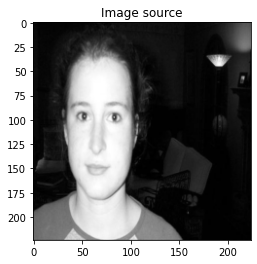

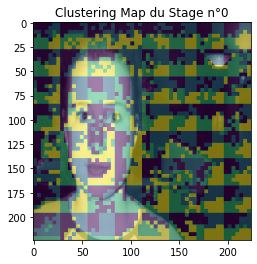

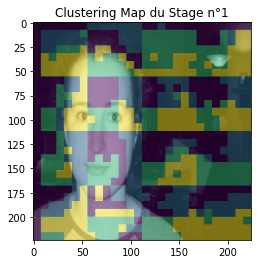

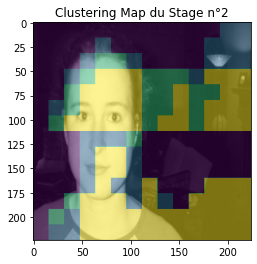

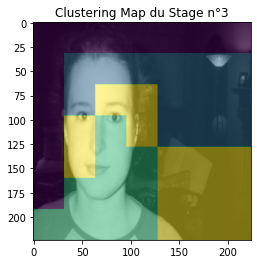

tensor(1957)


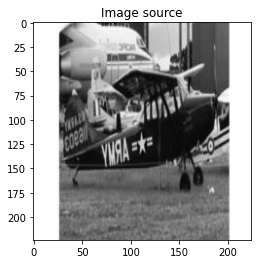

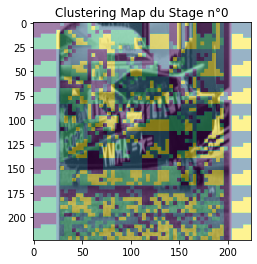

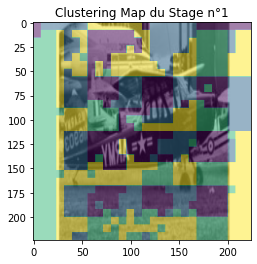

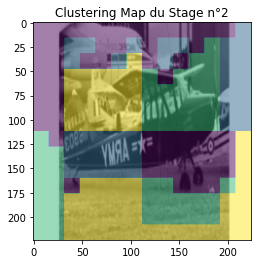

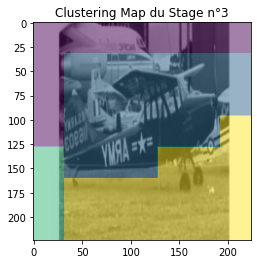

tensor(3009)


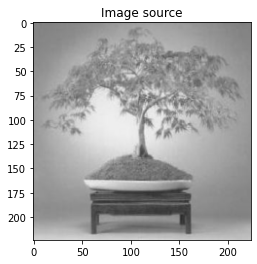

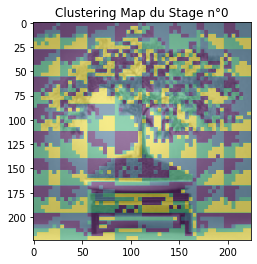

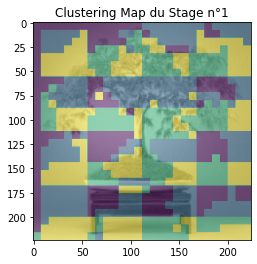

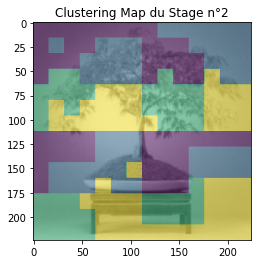

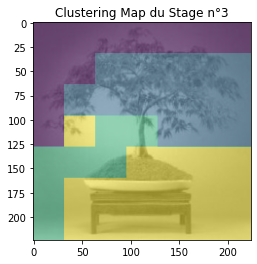

tensor(4604)


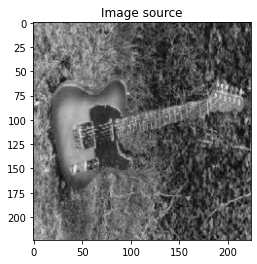

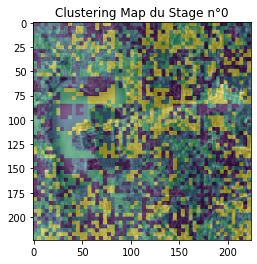

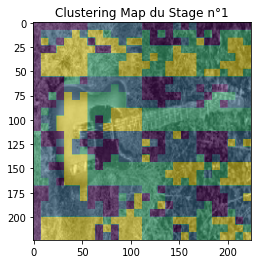

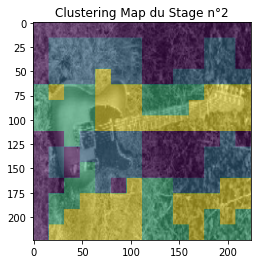

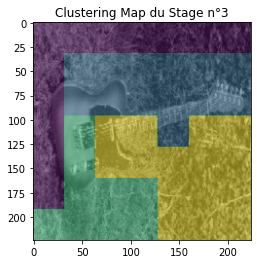

tensor(4855)


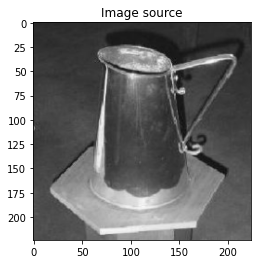

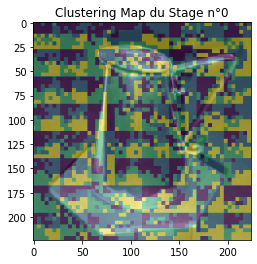

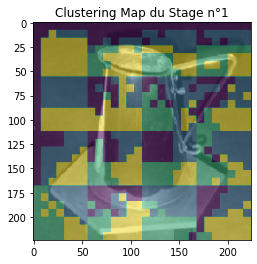

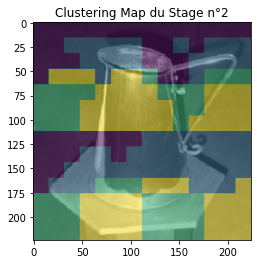

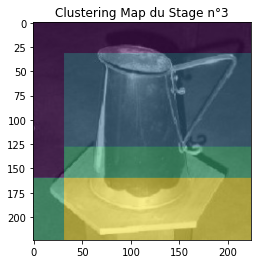

tensor(5184)


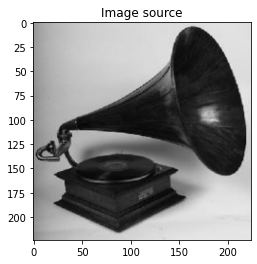

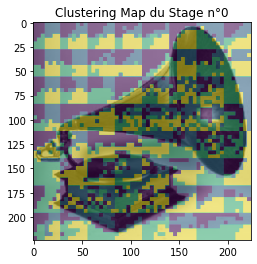

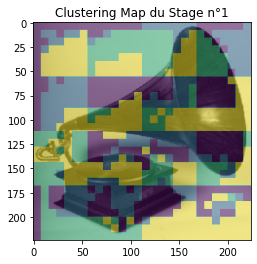

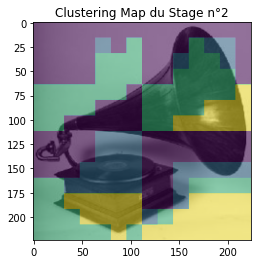

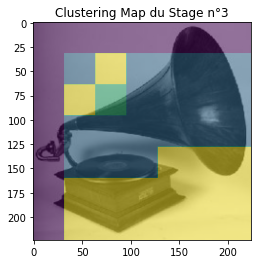

tensor(5295)


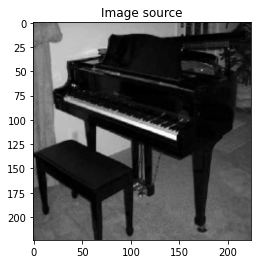

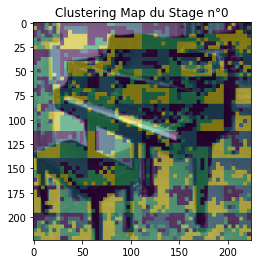

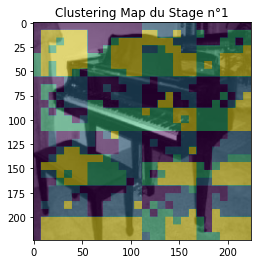

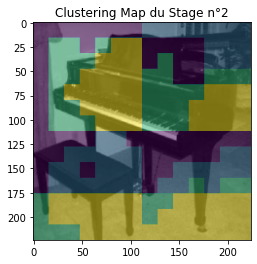

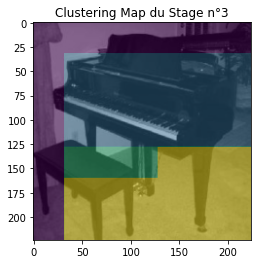

tensor(6778)


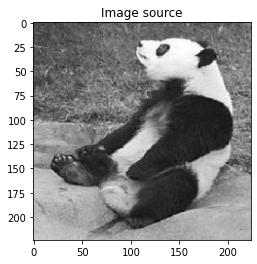

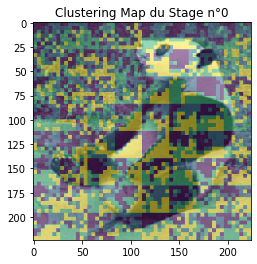

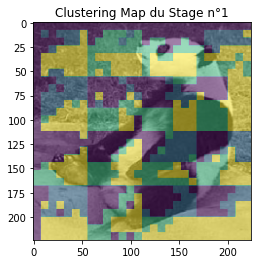

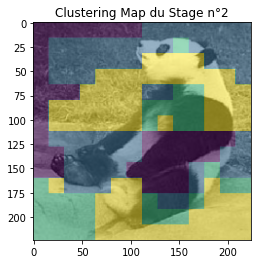

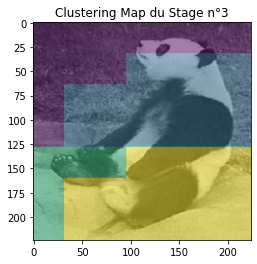

tensor(7244)


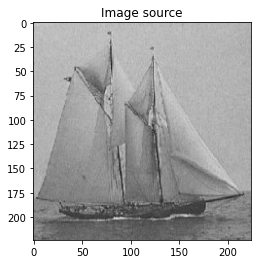

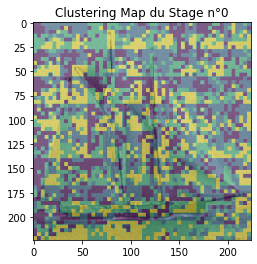

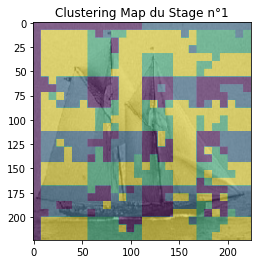

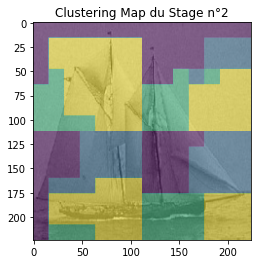

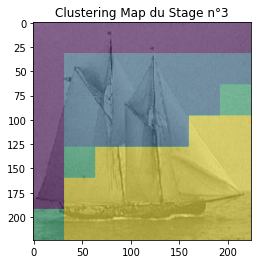

tensor(7885)


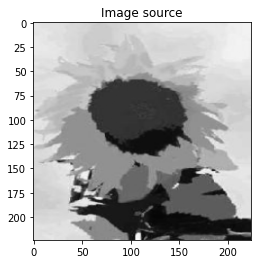

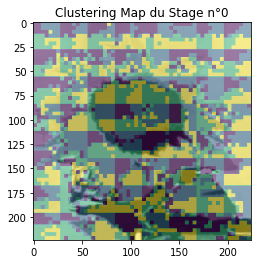

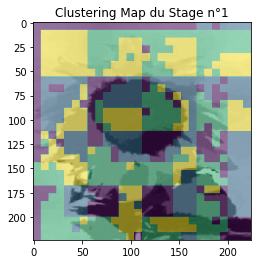

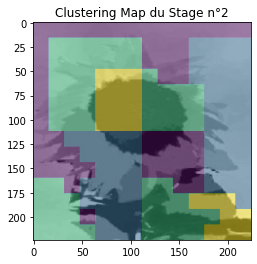

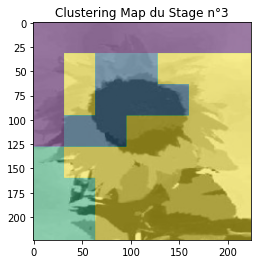

In [65]:
idx = torch.randint(len(dataset),(10,))
idx = torch.unique(idx)
for id in idx:
    print(id)
    get_clustering_maps(model,id,0.5)

## Cifar

In [91]:
n_blocks = [4,6,4]
embedding_sizes = [5,32,128]
head_counts = [4,4,8]
head_dims = [16,16,16]
mlp_ratios = [16,8,4]
folds = [2,1,1]
num_classes = 10
device = 'cuda'
model2 = Model(embedding_sizes,num_classes,n_blocks=n_blocks,head_counts=head_counts,head_dims=head_dims,mlp_ratios=mlp_ratios,dropout=0.5,droppath=0.2).to(device)
#summary(model2,(3,32,32))

In [ ]:
model2.load_state_dict(torch.load("models\model_super_small.pth"))
model2.eval()
model2 = model2.to(device)

In [92]:
test_dataset = datasets.CIFAR10(PATH, train=False, download=True,
transform=transforms.Compose([
    transforms.ToTensor (), # Transform the PIL image to a torch.Tensor
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
]))

img_dataset = datasets.CIFAR10(PATH, train=False, download=True,
transform=transforms.Compose([
    transforms.ToTensor (), # Transform the PIL image to a torch.Tensor
]))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar-10-python.tar.gz to datasets
Files already downloaded and verified


In [93]:
X,y = next(iter(test_dataset))
input = torch.zeros((1,3,32,32))
input[0] = X
input = input.to(device)
inp,masks = model2.getmask(input)
print(len(masks))

3


In [94]:
for i in masks:
    print(i.shape)

torch.Size([4, 4, 32, 32])
torch.Size([4, 4, 16, 16])
torch.Size([8, 4, 8, 8])


tensor([5453])


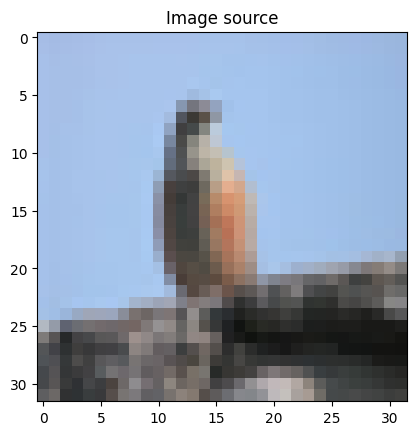

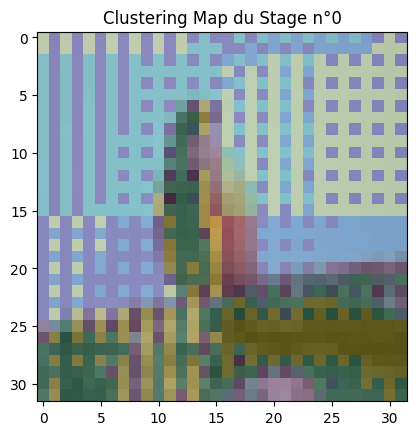

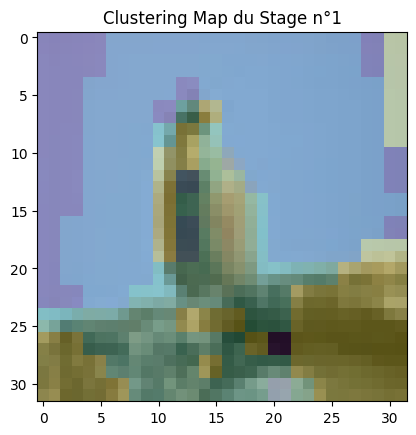

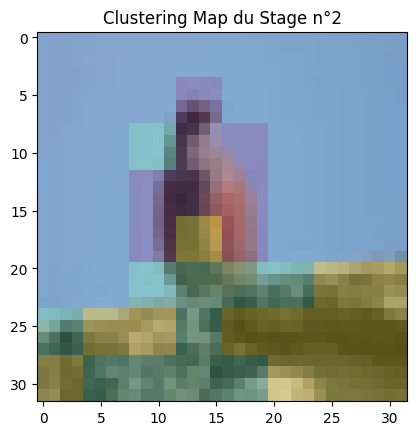

In [ ]:
idx = torch.randint(len(test_dataset),(1,))
print(idx)
get_clustering_maps(model2,idx,0.3)